In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import wandb
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
wandb.init(project='segmentation_deeplabv3', config={'epochs': 300, 'batch_size': 16,'learning_rate': 1e-4})
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kalinicheva2007 (pdftotex) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = sorted(f for f in os.listdir(image_dir) if f.endswith('.jpg'))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = os.path.splitext(img_name)[0] + '.png'  # имя маски совпадает с именем изображения, разница в расширении
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        #print("Mask range:", mask.min().item(), mask.max().item())

        return image, mask, img_name

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [6]:
images_dir = '/content/drive/MyDrive/Курсовая/images'
masks_dir = '/content/drive/MyDrive/Курсовая/masks_full'

In [7]:
dataset = CustomDataset(images_dir, masks_dir, image_transform=transform, mask_transform=mask_transform)

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
# val_size = int(0.15 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

In [8]:
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=config.batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_set, batch_size=config.batch_size, shuffle=False, num_workers=8)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
num_classes = 1
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [11]:
# для бинарной сегментации
# targets 0 или 1
# smooth чтобы на 0 не делить
def dice_loss(inputs, targets, smooth=1e-6):
    inputs = torch.sigmoid(inputs)  # преобразование логитов к [0, 1]
    inputs = inputs.view(-1)  # векторизуем
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice

# только dice loss не справлялся на нормальном уровне. по числам было ок, по картинкам ужас
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-6):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(weight=weight)
        self.smooth = smooth

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        d_loss = dice_loss(inputs, targets, smooth=self.smooth)
        return bce_loss + d_loss

In [12]:
criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks, img_name in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']  # [batch, num_classes, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks, img_name in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [14]:
def pixel_accuracy(pred, target):
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return correct / total

def iou_score(pred, target):
    pred = pred.long()
    target = target.long()
    intersection = (pred & target).float().sum(dim=(1,2,3))  # sum по C, H и W
    union = (pred | target).float().sum(dim=(1,2,3))
    iou = (intersection / (union + 1e-7)).mean()
    return iou

def dice_score(pred, target):
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum(dim=(1,2,3))
    dice = (2.0 * intersection) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + 1e-7)
    return dice.mean()

In [15]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)  # снижаем lr если val_loss не улучшается

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, save_path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_loss):  # если модель улучшилась, то сохраняем, если нет, то увеличиваем счётчик
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        if self.verbose:
            print(f'Сохранены новые лучшие веса модели в: {self.save_path}')

    def load_best_model(self, model):
        model.load_state_dict(torch.load(self.save_path))
        if self.verbose:
            print(f'Загружены лучшие веса модели из: {self.save_path}')

In [17]:
wandb.watch(model, log="all")
num_epochs = config.epochs
early_stopping = EarlyStopping(patience=5, verbose=True, save_path='/content/drive/MyDrive/Курсовая/best_model.pth')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    running_iou = 0.0
    running_dice = 0.0
    num_batches = 0

    for images, masks, filenames in train_loader:
        optimizer.zero_grad()
        if isinstance(masks, list):
            masks = torch.stack(masks, dim=0)
        images = images.to(device)
        masks = masks.to(device)

        try:
            outputs = model(images)['out']
        except Exception as e:
            print(f"Ошибка на изображении: {filenames}")
            print(f"Ошибка: {e}")
            break
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        running_acc += pixel_accuracy(preds, masks).item()
        running_iou += iou_score(preds, masks).item()
        running_dice += dice_score(preds, masks).item()
        num_batches += 1

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_iou = 0.0
    val_dice = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for images, masks, filenames in val_loader:
            if isinstance(masks, list):
                masks = torch.stack(masks, dim=0)
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            val_acc += pixel_accuracy(preds, masks).item()
            val_iou += iou_score(preds, masks).item()
            val_dice += dice_score(preds, masks).item()
            num_val_batches += 1

    val_loss /= num_val_batches
    val_acc  /= num_val_batches
    val_iou  /= num_val_batches
    val_dice /= num_val_batches

    epoch_loss = running_loss / num_batches
    epoch_acc  = running_acc / num_batches
    epoch_iou  = running_iou / num_batches
    epoch_dice = running_dice / num_batches

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Pixel Acc: {epoch_acc:.4f}, '
          f'IoU: {epoch_iou:.4f}, '
          f'Dice: {epoch_dice:.4f}')

    wandb.log({'epoch': epoch + 1,
               'train_loss': epoch_loss,
               'val_loss': val_loss,
               'pixel_accuracy': epoch_acc,
               'iou': epoch_iou,
               'dice': epoch_dice})

    scheduler.step(epoch_loss)
    if early_stopping(model, val_loss):
        print('Остановка обучения. Сохранение лучших весов.')
        break

Epoch [1/300], Train Loss: 0.3281, Val Loss: 0.2063, Pixel Acc: 0.9472, IoU: 0.8345, Dice: 0.9085
Сохранены новые лучшие веса модели в: /content/drive/MyDrive/Курсовая/best_model.pth
Epoch [2/300], Train Loss: 0.1855, Val Loss: 0.1823, Pixel Acc: 0.9603, IoU: 0.8789, Dice: 0.9360
Сохранены новые лучшие веса модели в: /content/drive/MyDrive/Курсовая/best_model.pth
Epoch [3/300], Train Loss: 0.1572, Val Loss: 0.1633, Pixel Acc: 0.9631, IoU: 0.8874, Dice: 0.9412
Сохранены новые лучшие веса модели в: /content/drive/MyDrive/Курсовая/best_model.pth
Epoch [4/300], Train Loss: 0.1313, Val Loss: 0.1652, Pixel Acc: 0.9673, IoU: 0.8996, Dice: 0.9488
EarlyStopping counter: 1/5
Epoch [5/300], Train Loss: 0.1175, Val Loss: 0.1698, Pixel Acc: 0.9696, IoU: 0.9062, Dice: 0.9527
EarlyStopping counter: 2/5
Epoch [6/300], Train Loss: 0.1158, Val Loss: 0.1624, Pixel Acc: 0.9696, IoU: 0.9078, Dice: 0.9539
Сохранены новые лучшие веса модели в: /content/drive/MyDrive/Курсовая/best_model.pth
Epoch [7/300], Tra

In [18]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Курсовая/best_model.pth', map_location=device))
model.to(device)
model.eval()

test_loss = 0.0
test_acc = 0.0
test_iou = 0.0
test_dice = 0.0
num_batches = 0

with torch.no_grad():
    for images, masks, filenames in test_loader:
        try:
            if isinstance(masks, list):
                masks = torch.stack(masks, dim=0)
            masks = masks.to(device)
            images = images.to(device)

            outputs = model(images)['out']
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            test_acc += pixel_accuracy(preds, masks).item()
            test_iou += iou_score(preds, masks).item()
            test_dice += dice_score(preds, masks).item()
            num_batches += 1
        except FileNotFoundError as e:
            print(f'Ошибка: {e} — пропускаем {filenames}')
            continue
        except Exception as e:
            print(f'Ошибка с {filenames}: {e}')
            continue

test_loss /= num_batches
test_acc /= num_batches
test_iou /= num_batches
test_dice /= num_batches

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Pixel Accuracy: {test_acc:.4f}')
print(f'Test IoU: {test_iou:.4f}')
print(f'Test Dice: {test_dice:.4f}')

Test Loss: 0.1620
Test Pixel Accuracy: 0.9605
Test IoU: 0.8939
Test Dice: 0.9415


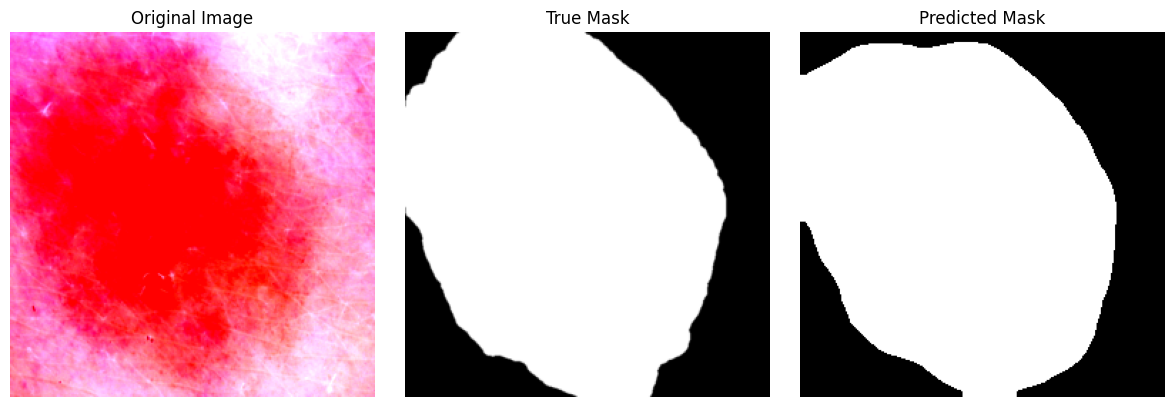

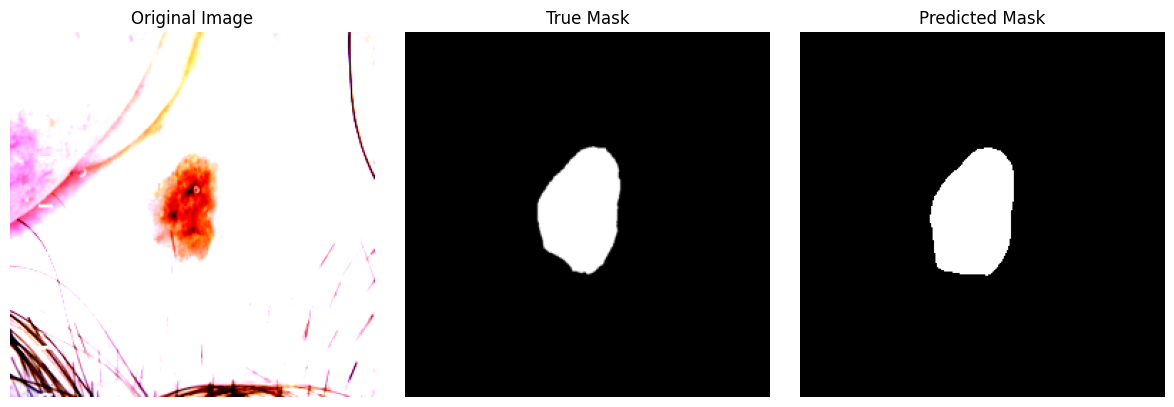

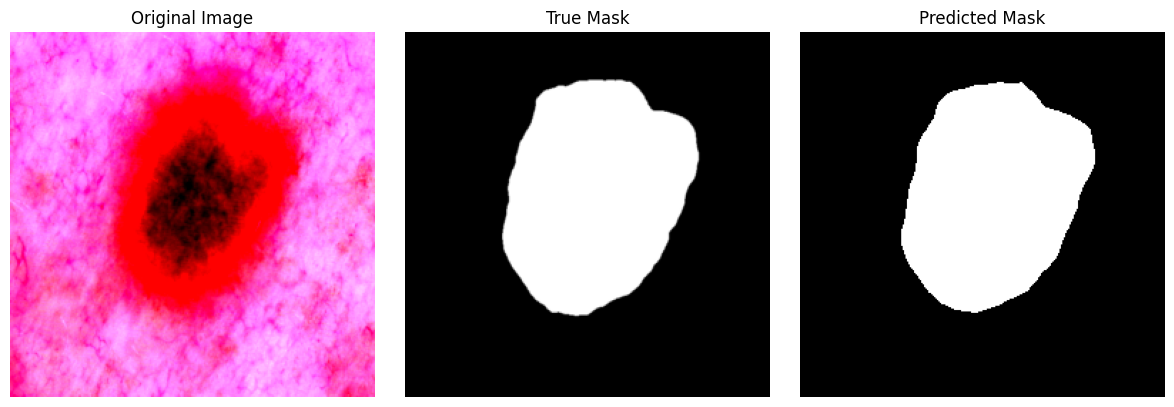

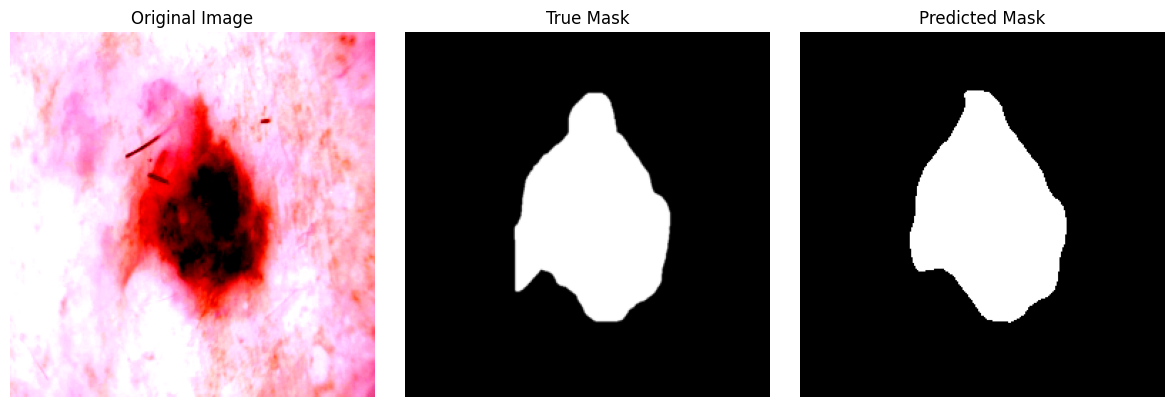

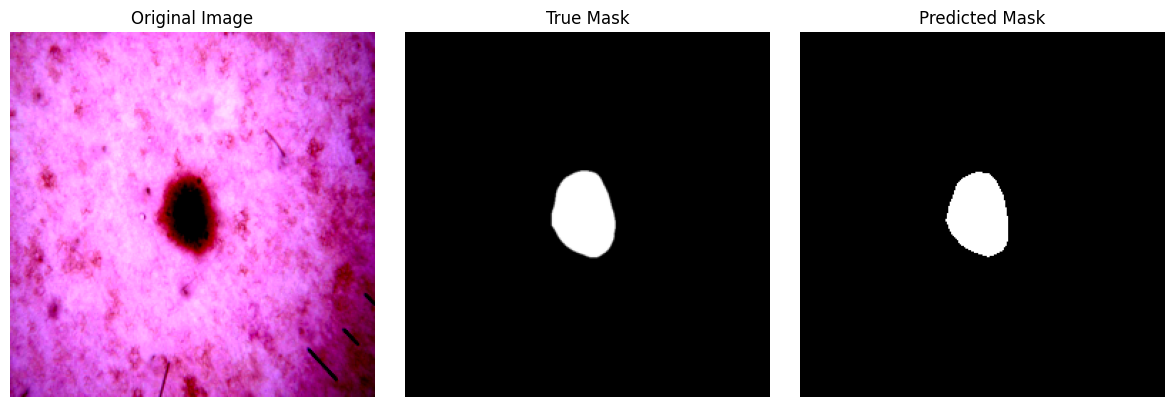

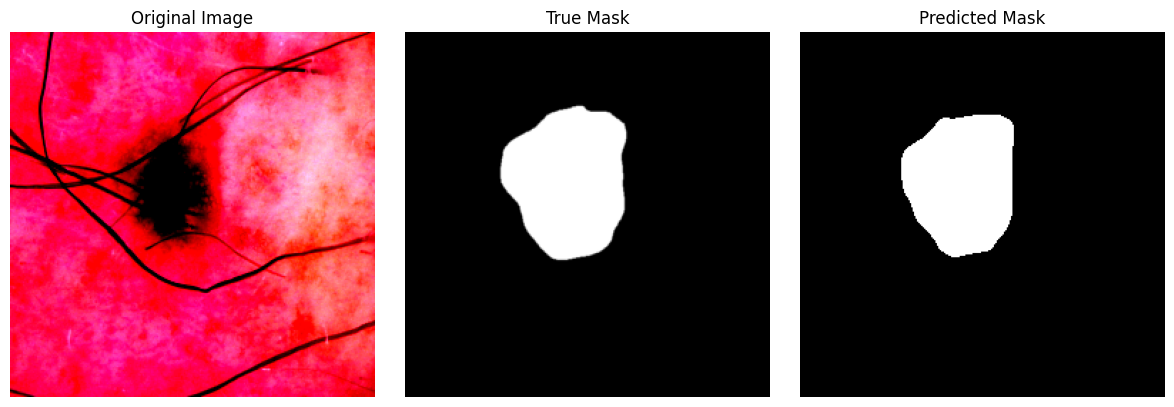

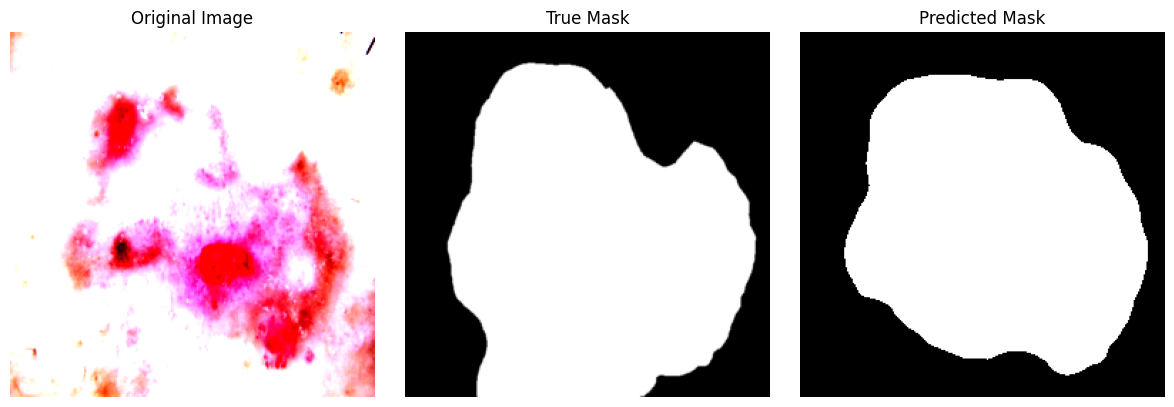

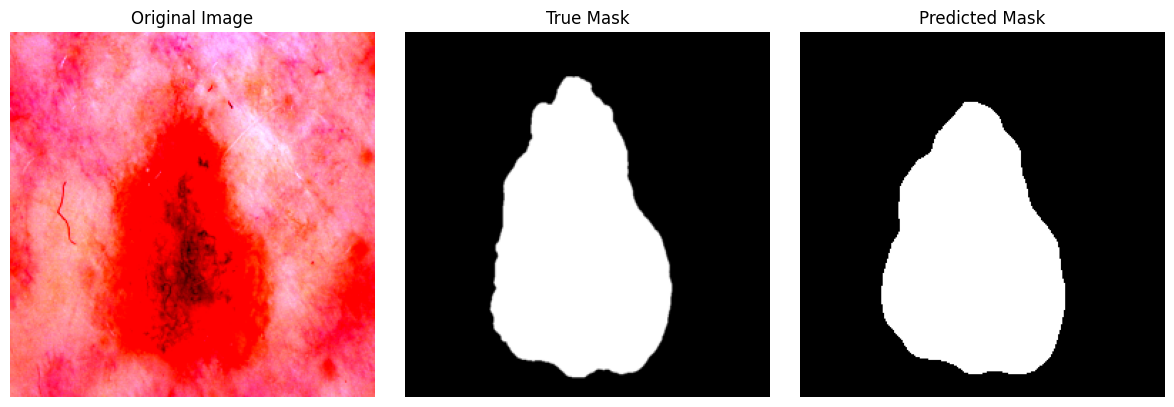

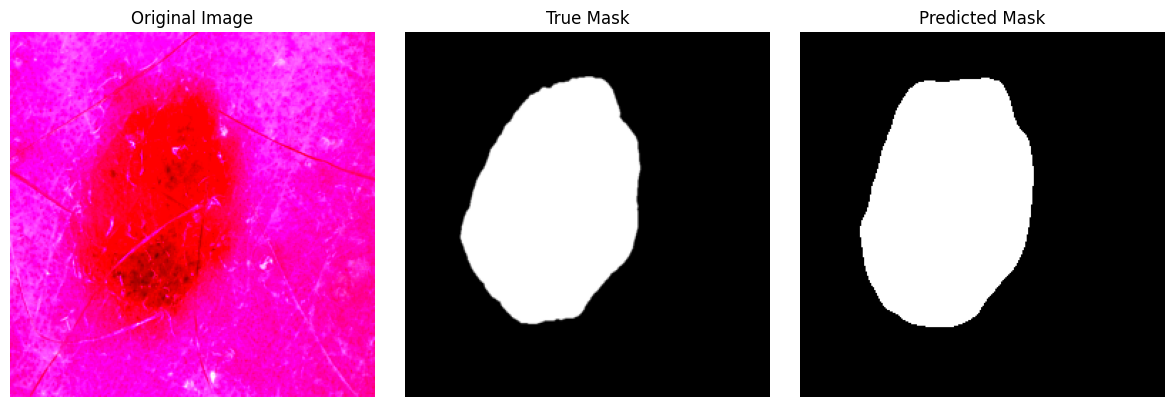

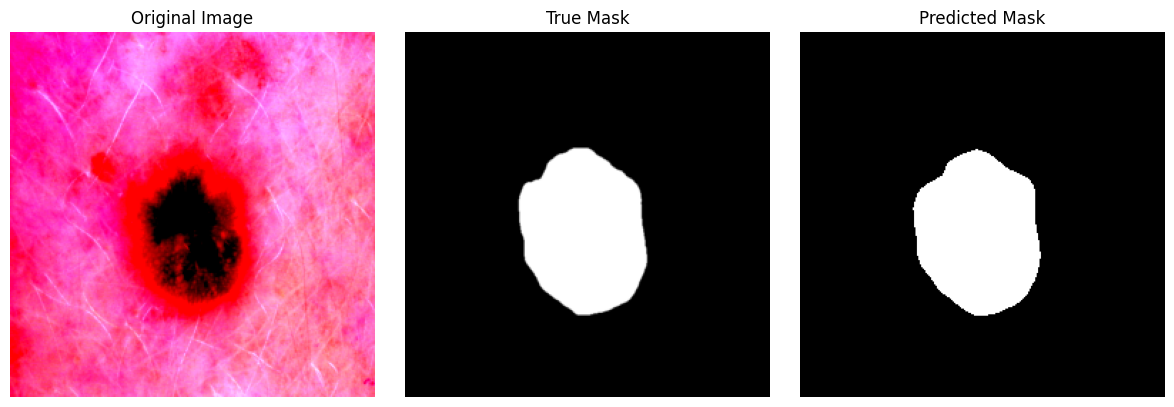

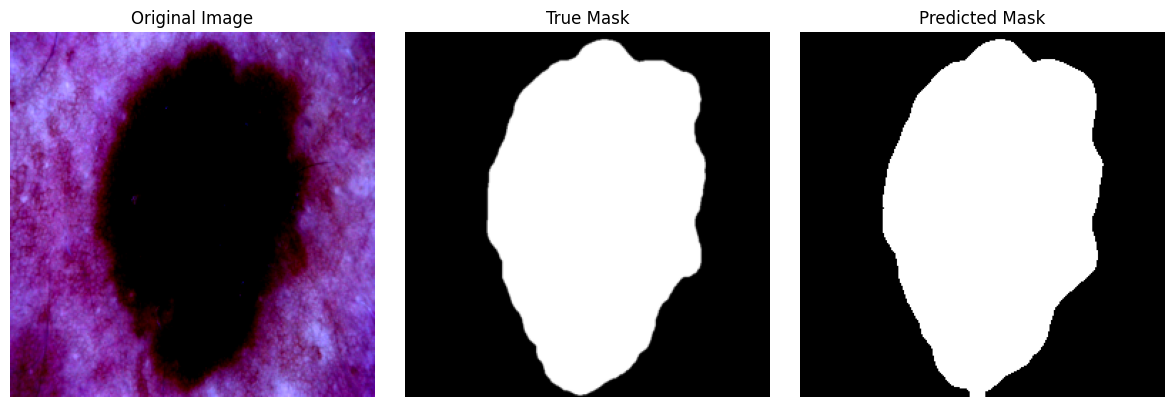

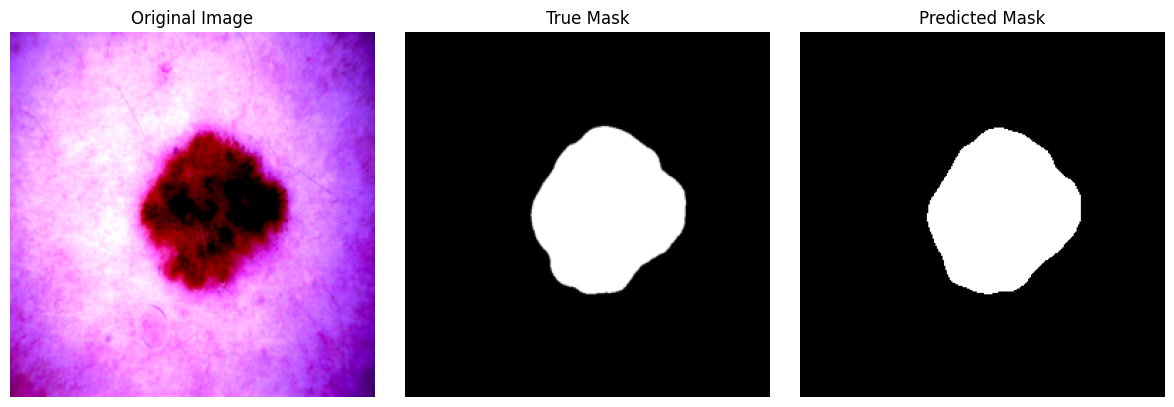

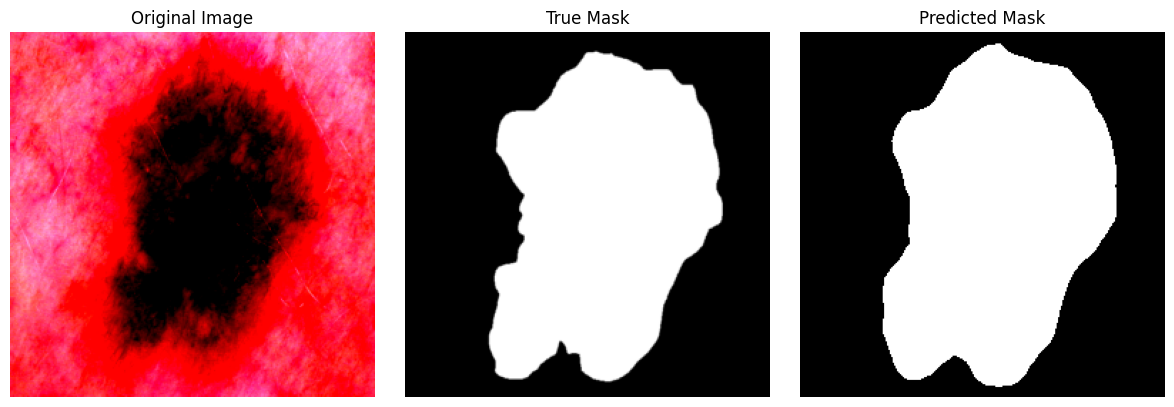

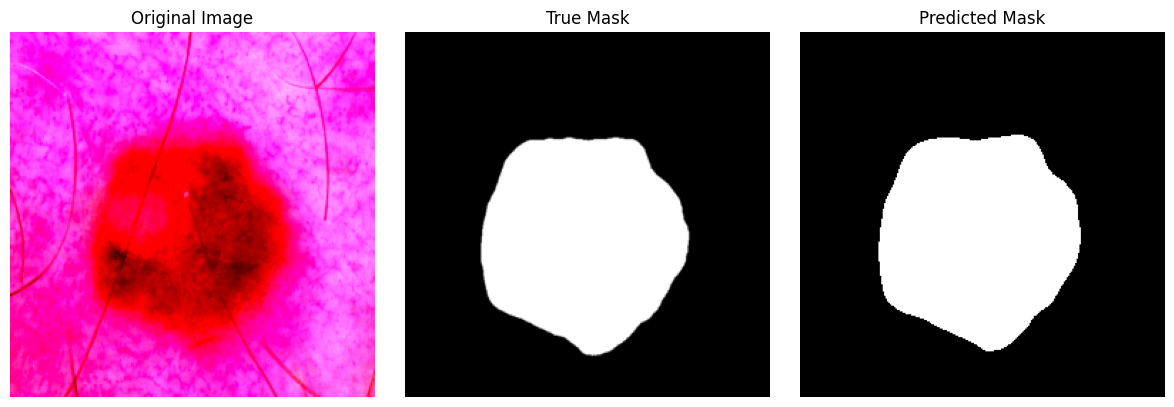

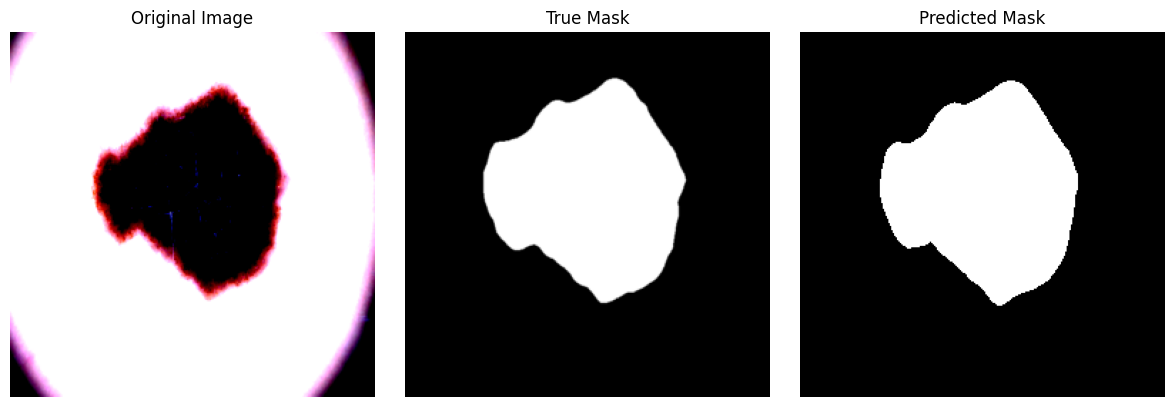

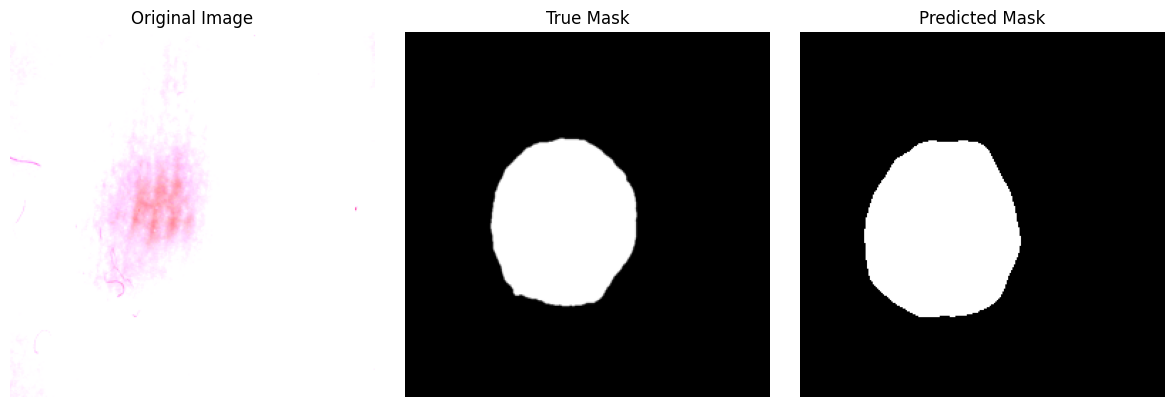

In [19]:
images, masks, filenames = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(images)['out']
    outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.sigmoid(outputs) > 0.5

for i in range(len(images)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].squeeze().cpu().numpy(), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze().cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

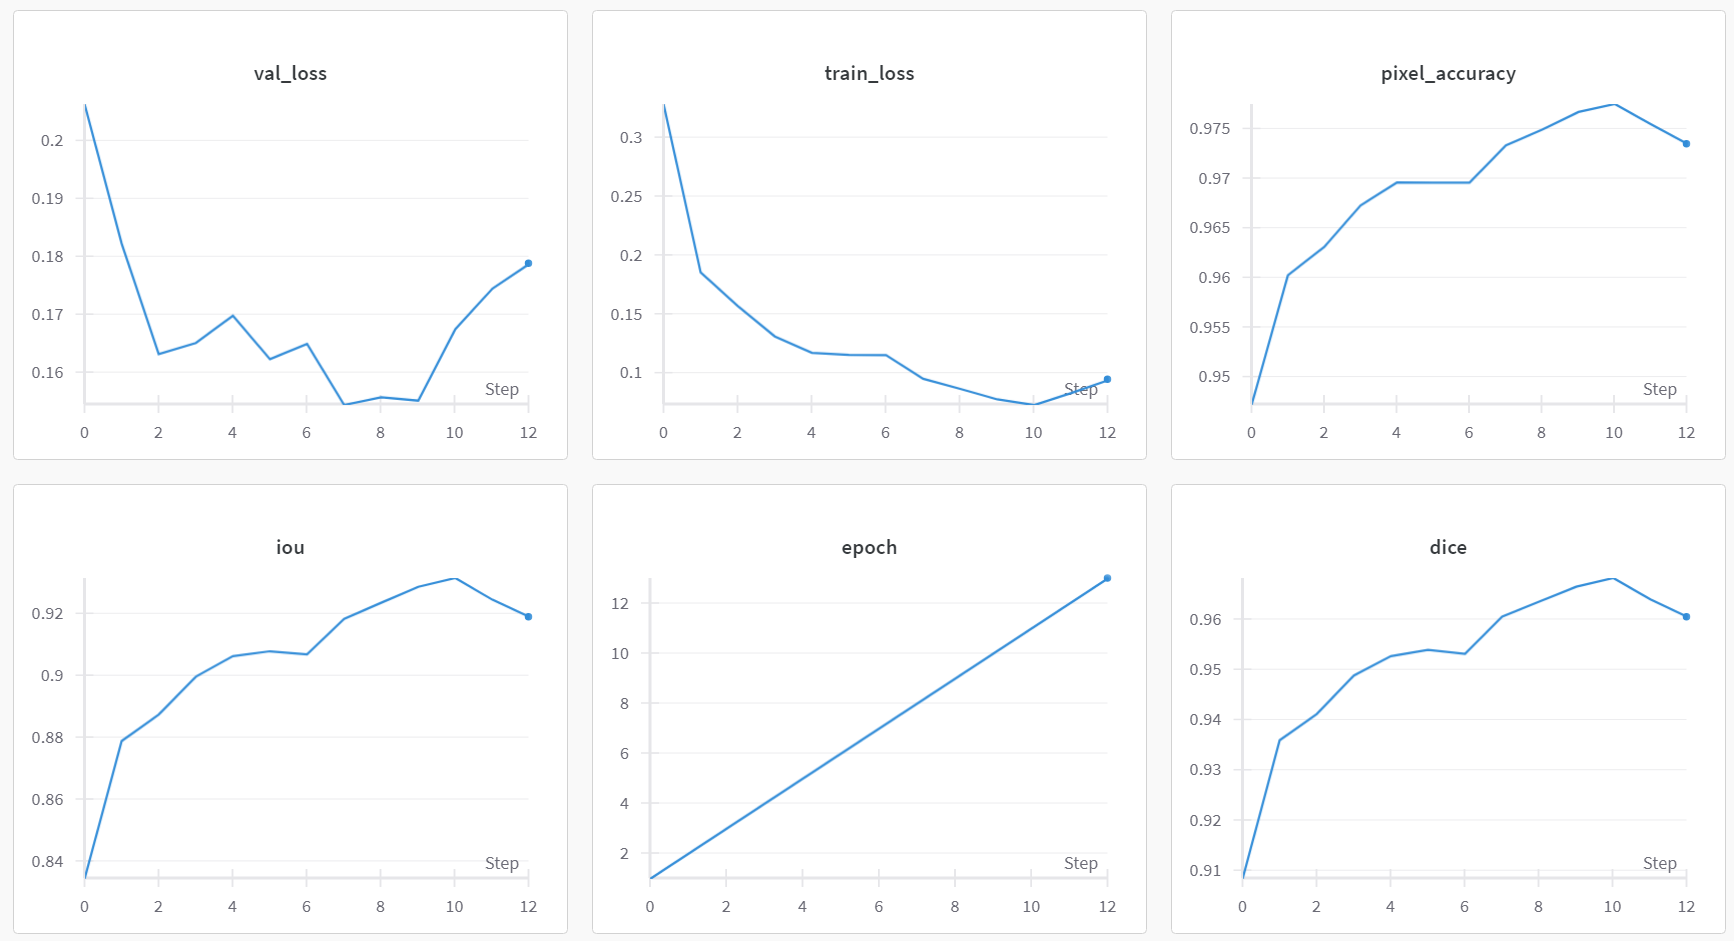

In [20]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.218
cache size	: 39424 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities
bugs		: spectre_v1 spectre_v2 spec_store_bypass swapgs ta

In [21]:
!uname -a

Linux a9d0032b908b 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


In [22]:
import torchvision
print('torch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
